In [2]:
from obspy import UTCDateTime
import obspy as obs
from obspy.clients.fdsn import Client as FDSN_Client
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [3]:
t1 = UTCDateTime("2009-03-24")
t2 = UTCDateTime("2009-03-30")
stname = ['SND']
network = 'AZ'
org = 'IRIS'

client = FDSN_Client(org)


for i, comp in enumerate(['HHE', 'HHN', 'HHZ']):
  land_st1 = client.get_waveforms(network, str(stname[0]), "*", str(comp), t1, t2)
land_st1_original = land_st1.copy()
land_st1 = land_st1_original.copy()
land_st1.detrend()
land_st1.taper(max_percentage=0.05)
land_st1.filter('highpass', freq=2)


In [118]:
import sys
sys.path.append("../")
from ground_motion_qh import extract_pairs

In [38]:
import pandas as pd
df = pd.DataFrame(
    land_st1[0].times(),
    land_st1[0].data,
)
df.reset_index(inplace=True)
df.columns = ['time', 'acc']

In [40]:
df.to_csv('../data/one_week_wave.csv', index=False)

In [156]:
selected_times = np.random.choice(land_st1[0].times(), 10000, replace=False)

TW_MINUS = 10
TW_BUFFER = 10
TW_PLUS = 10

a_minus_vector, a_plus_vector = extract_pairs.waveform_to_max_amp_pairs(
    selected_times,
    land_st1[0].data,
    land_st1[0].times(),
    tw_minus=TW_MINUS,
    tw_plus=TW_PLUS,
    tw_buffer=TW_BUFFER,
)

a_plus_vector_shuffled = np.random.permutation(a_plus_vector)

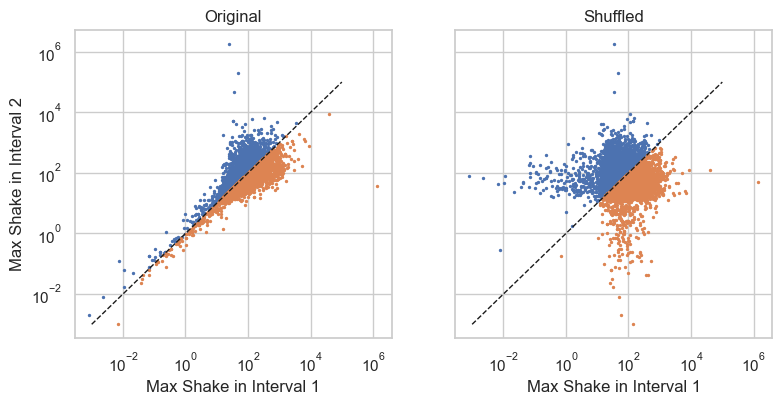

In [160]:
above_logical = a_plus_vector>a_minus_vector
above_logical_shuffled = a_plus_vector_shuffled>a_minus_vector

fig, axes = plt.subplots(figsize = (9,4), ncols=2, sharey=True, sharex=True)

for ax in axes:
    if ax == axes[1]:
        ax.set_title('Shuffled')
        ax.scatter(a_minus_vector[above_logical_shuffled], a_plus_vector_shuffled[above_logical_shuffled], s=2)
        ax.scatter(a_minus_vector[~above_logical_shuffled], a_plus_vector_shuffled[~above_logical_shuffled], s=2)
    else:
        ax.scatter(a_minus_vector[above_logical], a_plus_vector[above_logical], s=2)
        ax.scatter(a_minus_vector[~above_logical], a_plus_vector[~above_logical], s=2)
        ax.set_title('Original')
        ax.set_ylabel('Max Shake in Interval 2')
    ax.set_xlabel('Max Shake in Interval 1')
    ax.plot([1e-3, 1e5], [1e-3, 1e5], 'k--', lw=1, label='x = y')

    ax.set_xscale("log")
    ax.set_yscale("log")

plt.show()

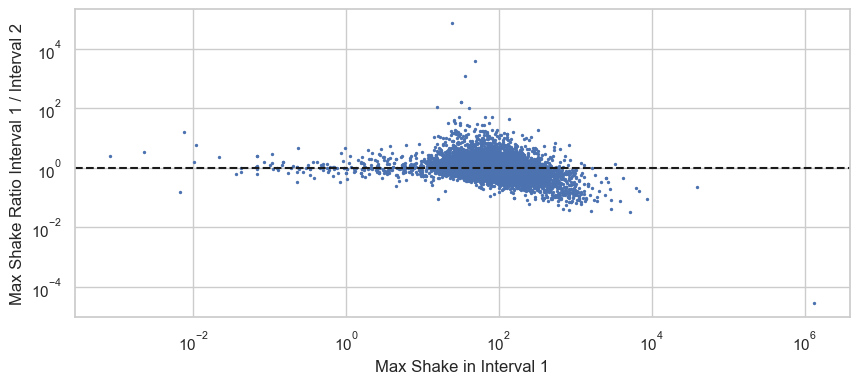

In [163]:
above_logical = a_plus_vector>a_minus_vector

fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(a_minus_vector, a_plus_vector/a_minus_vector, s=2)
ax.axhline(1, color='k', linestyle='--')
ax.set_xlabel('Max Shake in Interval 1')
ax.set_ylabel('Max Shake Ratio Interval 2 / Interval 1')
np.mean(a_plus_vector>a_minus_vector)


ax.set_xscale("log")
ax.set_yscale("log")

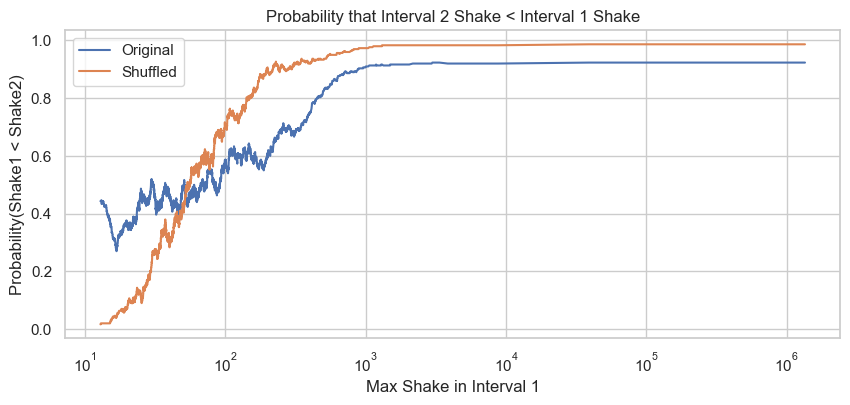

In [169]:
n_roll = 300
sort_a_minus = np.argsort(a_minus_vector)
a_minus_vector = a_minus_vector[sort_a_minus]
a_plus_vector = a_plus_vector[sort_a_minus]

ratios = a_plus_vector/a_minus_vector
ratios_shuffled = a_plus_vector_shuffled/a_minus_vector


rolling_ratio = [(((ratios) > 1)[i: i+n_roll]).mean() for i in np.arange(len(a_plus_vector)-n_roll)]
rolling_ratio_shuffled = [(((ratios_shuffled) > 1)[i: i+n_roll]).mean() for i in np.arange(len(a_plus_vector)-n_roll)]


fig, ax = plt.subplots(figsize = (10,4))
ax.plot(
    a_minus_vector[n_roll:],
    1-np.array(rolling_ratio),
    label='Original'
)
ax.plot(
    a_minus_vector[n_roll:],
    1-np.array(rolling_ratio_shuffled),
    label='Shuffled'
)
plt.xscale("log")
plt.xlabel('Max Shake in Interval 1')
plt.ylabel('Probability(Shake1 < Shake2)')
plt.title('Probability that Interval 2 Shake < Interval 1 Shake')
plt.legend()
plt.show()

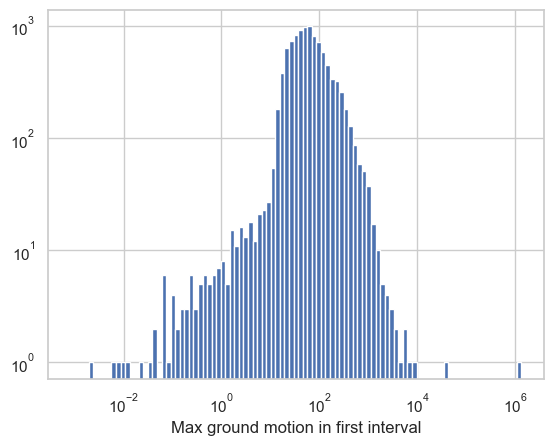

In [170]:
# logarithmic bins
log_bins = np.logspace(
    np.log10(np.min(a_minus_vector)),
    np.log10(np.max(a_minus_vector)),
    100
)
plt.hist(a_minus_vector, bins=log_bins)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Max ground motion in first interval')
plt.show()

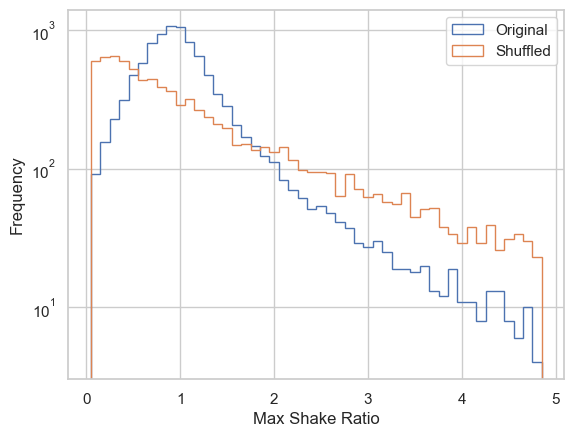

In [199]:
bin_size = 0.1
x_vals = np.arange(0, 5, bin_size)
plt.hist(
    a_plus_vector / a_minus_vector,
    bins=x_vals[:-1] + bin_size / 2,
    label='Original',
    histtype='step'
)

plt.hist(
    a_plus_vector_shuffled / a_minus_vector,
    bins=x_vals[:-1] + bin_size / 2,
    label='Shuffled',
    histtype='step'
)

plt.yscale("log")
plt.xlabel("Max Shake Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()

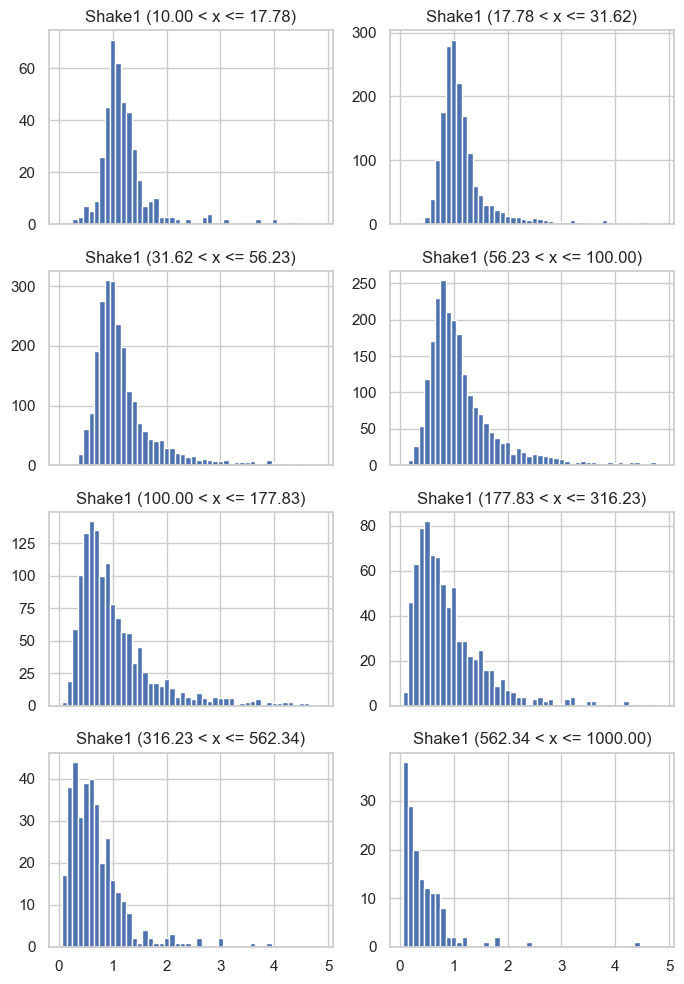

In [250]:
a_minus_bins = np.power(10, np.arange(1.0, 3.1, 0.25))
bin_size = 0.1
x_vals = np.arange(0, 5, bin_size)

ratios_in_bins = []


fig, axes  = plt.subplots(figsize=(7,10), nrows=(len(a_minus_bins)-1)//2, ncols=2, sharex=True, tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    lower = a_minus_bins[i]
    upper = a_minus_bins[i+1]

    logical = (a_minus_vector > lower) & (a_minus_vector <= upper)

    ratio_in_bin = a_plus_vector[logical] / a_minus_vector[logical]
    ratios_in_bins.append(np.clip(ratio_in_bin, 0, 5))
    ratio_in_bin_shuffled = a_plus_vector_shuffled[logical] / a_minus_vector[logical]
    ax.hist(
        ratio_in_bin,
        bins=x_vals[:-1] + bin_size / 2,
        label='Original',
        # histtype='step'
    )
    # ax.hist(
    #     ratio_in_bin_shuffled,
    #     bins=x_vals[:-1] + bin_size / 2,
    #     label='Shuffled',
    #     histtype='step'
    # )
    ax.set_title(f"Shake1 ({lower:.2f} < x <= {upper:.2f})")


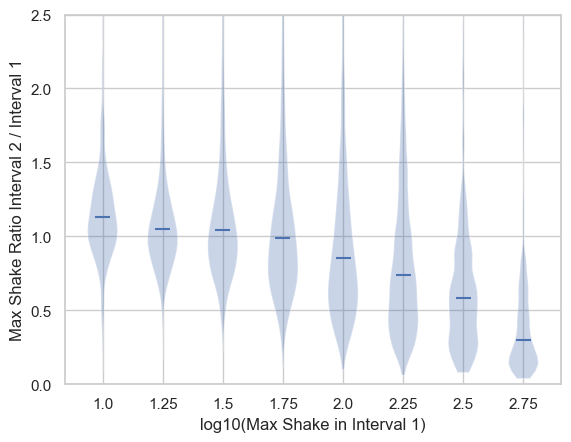

In [251]:
plt.violinplot(
    ratios_in_bins,
    # positions=np.log10(a_minus_bins[:-1]),
    showmeans=False,
    showmedians=True,
    showextrema=False,
    bw_method=0.1
)
plt.xticks(
    np.arange(1, len(a_minus_bins)),
    np.log10(a_minus_bins[:-1])
)
plt.xlabel('log10(Max Shake in Interval 1)')
plt.ylabel('Max Shake Ratio Interval 2 / Interval 1')
plt.ylim(0, 2.5)
plt.show()

NameError: name 'a_minus_bins' is not defined